In [1]:
import os
import pandas as pd 
import numpy as np 

# visualisation
import matplotlib.pylab as plt
import matplotlib.font_manager as fm

# our scripts 
import src.processing as sp 
import settings as st
import utils.helpers as hp
import utils.imaging as ui

### Correct for the locations of the images 

In [2]:
%%capture
!git pull

In [3]:
# dr5_desc = sp.correct_location('gz_decals_volunteers_5', save = True, filename='dr5_votes')

### The data with the votes

In [2]:
dataframe = hp.read_parquet(st.DATA_DIR, 'descriptions/dr5_votes')

In [3]:
labels = sp.generate_labels(dataframe, save=False)

In [4]:
labels.head()

,iauname,png_loc,Smooth,Featured or Disk,Artifact,Round,In Between,Cigar Shaped,Edge On Disk (Yes),Edge On Disk (No),...,Spiral Arms (2),Spiral Arms (3),Spiral Arms (4),Spiral Arms (More Than 4),Spiral Arms (cannot tell),Central Bulge (None),Central Bulge (Small),Central Bulge (Moderate),Central Bulge (Large),Central Bulge (Dominant)
0,J112953.88-000427.4,J112/J112953.88-000427.4.png,1,0,0,0,0,1,0,1,...,0,0,0,0,1,0,0,1,0,0
1,J104325.29+190335.0,J104/J104325.29+190335.0.png,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,1
2,J104629.54+115415.1,J104/J104629.54+115415.1.png,0,1,0,0,1,0,0,1,...,1,0,0,0,0,0,1,1,0,0
3,J082950.68+125621.8,J082/J082950.68+125621.8.png,0,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,J122056.00-015022.0,J122/J122056.00-015022.0.png,0,1,0,0,1,0,0,1,...,1,0,0,0,0,0,0,1,0,0


In [5]:
# labels.to_csv('ml/labels.csv')

# Calculate the weights per class

In [5]:
labels_num = labels.iloc[:,2:]
weights = labels_num.sum(axis=0)
inv_weights = 1/weights
inv_weights_norm = inv_weights/inv_weights.sum()

In [6]:
inv_weights_norm

Smooth                         0.002821
Featured or Disk               0.005690
Artifact                       0.057493
Round                          0.006431
In Between                     0.003816
Cigar Shaped                   0.011399
Edge On Disk (Yes)             0.010705
Edge On Disk (No)              0.003131
Merging (Merger)               0.024418
Merging (Major Disturbance)    0.041934
Merging (Minor Disturbance)    0.017971
Merging (None)                 0.002253
Bulge (Rounded)                0.008159
Bulge (Boxy)                   0.057669
Bulge (None)                   0.023825
No Bar                         0.003642
Weak Bar                       0.014607
Strong Bar                     0.029243
Spiral Arms (Yes)              0.006750
Spiral Arms (No)               0.004657
Spiral Winding (Tight)         0.010099
Spiral Winding (Medium)        0.013962
Spiral Winding (Loose)         0.020519
Spiral Arms (1)                0.055613
Spiral Arms (2)                0.009501


# Split into train, test and validate

In [8]:
train_val_test = sp.split_data(labels, 0.05, 0.15, save=False)

In [9]:
train_val_test['train'].shape

(202628, 36)

In [10]:
train_val_test['validate'].shape

(12665, 36)

In [11]:
train_val_test['test'].shape

(37993, 36)

In [12]:
labels.shape

(253286, 36)

### DataLoader

In [3]:
from src.dataset import DECaLSDataset
from torch.utils.data import Dataset, DataLoader

In [4]:
traindataset = DECaLSDataset(mode = 'train', augment = False, multi_task = True)

The number of training points is 189963


In [10]:
train_loader = DataLoader(dataset=traindataset, batch_size=4, shuffle=True)

In [11]:
dataiter = iter(train_loader)

In [12]:
data = dataiter.next()

In [20]:
sp.find_labels({'task_'+str(i+1): data[1][i][2].tolist() for i in range(10)})

array(['Featured or Disk', 'Edge On Disk (Yes)', 'Bulge (Rounded)',
       'Merging (None)'], dtype='<U27')

# Test Network

In [336]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

# our scripts and functions
from src.network import MultiLabelNet, MultiTaskNet
from src.dataset import DECaLSDataset
import settings as st

In [337]:
out_path = './output/'
os.makedirs(out_path, exist_ok=True)

# Set device to CUDA if a CUDA device is available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# create the dataloader
train_dataset = DECaLSDataset(mode='train', augment=False, multi_task = True)
val_dataset = DECaLSDataset(mode='validate', augment=False, multi_task = True)

train_loader = DataLoader(dataset=train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=4, shuffle=False)

The number of training points is 202628
The number of validation points is 12665


In [3]:
# %%capture
# model = MultiLabelNet(backbone="resnet18")
# model.to(device)

In [338]:
LABELS_PER_TASK = {'task_1': 3,
                   'task_2': 3,
                   'task_3': 2,
                   'task_4': 4,
                   'task_5': 3,
                   'task_6': 3,
                   'task_7': 2,
                   'task_8': 3,
                   'task_9': 6,
                   'task_10': 5
                   }

In [339]:
%%capture
model = MultiTaskNet(backbone="resnet18", output_size=LABELS_PER_TASK, resnet_task = True)
model.to(device)

In [6]:
data = next(iter(train_loader))

In [7]:
def criterion(loss, outputs: nn.ModuleDict, labels: dict) -> torch.tensor:
    losses = 0
    for i, key in enumerate(outputs):
        # print(outputs[key])
        # print(labels[key])
        losses += loss(outputs[key], labels[key].float().to(device))
    return losses

In [7]:
outputs = model(data[0].to(device))

In [8]:
outputs = model(data[0].to(device))
labels = data[1]
loss = nn.BCEWithLogitsLoss()
l = criterion(loss, outputs, labels)

# If We Want to Use Shared Representation

- Also implemented a ResNet in 1D. 

In [ ]:
import torch.nn.functional as F

In [26]:
tf_last_layer_chopped = nn.Sequential(*list(model.children())[:-1])

In [32]:
feat = tf_last_layer_chopped(data[0].to(device))

In [34]:
f = feat.to('cpu')

In [69]:
conv1 = nn.Conv1d(1, 1, kernel_size=3, stride=2, padding = (3 - 1)//2)
bn1 = nn.BatchNorm1d(1)
conv2 = nn.Conv1d(1, 1, kernel_size=3, stride=2, padding = (3 - 1)//2)
bn2 = nn.BatchNorm1d(1)

In [99]:
features = f.unsqueeze(1)

In [100]:
out = conv1(features)
out = bn1(out)
out = F.relu(out)
out = conv2(out)
out = bn2(out)

In [101]:
nout = out.shape[-1]
nfeat = features.shape[-1]
left = (1000 - nout) // 2
right = 1000 - left - nout

In [102]:
out = F.pad(input=out, pad=(left, right), mode='constant', value=0)

In [103]:
out += features
out = F.relu(out)

In [107]:
out = conv1(out)
out = bn1(out)
out = F.relu(out)
out = conv2(out)
out = bn2(out)

In [108]:
out.shape

torch.Size([4, 1, 250])

In [138]:
resnet_layer = nn.Sequential(*list(model.children())[:-1])

In [135]:
model_1 = nn.Sequential(*list(model.children())[1]['task_1'].layers[:-1])

In [137]:
# from torchsummary import summary
# summary(model, (1, 224, 224))

In [1]:
import os

In [2]:
os.path.join('a', 'b', 'c')

'a/b/c'

# Embedding Vector

In [74]:
import torch
import torch.nn as nn 
from src.network import MultiLabelNet
from src.dataset import DECaLSDataset
from torch.utils.data import DataLoader
import settings as st

import os
from PIL import Image
import matplotlib.pylab as plt

In [75]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [76]:
# load the model
%%capture
loaded_model = torch.load('../ml-models/resnet_18_multilabel_24.pth')
model = MultiLabelNet(backbone="resnet18")
model.to(device)
model.load_state_dict(loaded_model)
model.eval()

UsageError: Line magic function `%%capture` not found.


In [77]:
tf_last_layer_chopped = nn.Sequential(*list(model.children())[:-1])

In [78]:
test_dataset = DECaLSDataset(mode='test', augment=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

The number of test points is 50658


In [96]:
d1 = test_loader.dataset[0]
d2 = test_loader.dataset[1]
d3 = test_loader.dataset[2]
d4 = test_loader.dataset[3]

In [97]:
o1 = tf_last_layer_chopped(d1[0].view(1,1,224,224).to(device))
o2 = tf_last_layer_chopped(d2[0].view(1,1,224,224).to(device))
o3 = tf_last_layer_chopped(d3[0].view(1,1,224,224).to(device))
o4 = tf_last_layer_chopped(d4[0].view(1,1,224,224).to(device))

In [81]:
d1[1]

tensor([1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
        0, 1, 0, 0, 0, 0, 1, 0, 0, 0])

In [82]:
d2[1]

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [83]:
d3[1]

tensor([0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [98]:
d4[1]

tensor([0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

### Pairwise Distance

In [92]:
pdist = nn.PairwiseDistance(p=2)

In [93]:
pdist(o1, o2)

tensor([7.0306], device='cuda:0', grad_fn=<NormBackward1>)

In [94]:
pdist(o1, o3)

tensor([6.3318], device='cuda:0', grad_fn=<NormBackward1>)

In [95]:
pdist(o2, o3)

tensor([7.0053], device='cuda:0', grad_fn=<NormBackward1>)

In [103]:
pdist(o1, o4)

tensor([8.2538], device='cuda:0', grad_fn=<NormBackward1>)

In [104]:
pdist(o2, o4)

tensor([9.2016], device='cuda:0', grad_fn=<NormBackward1>)

In [105]:
pdist(o3, o4)

tensor([6.2826], device='cuda:0', grad_fn=<NormBackward1>)

### Cosine Similarity

In [84]:
cos = nn.CosineSimilarity(dim=1, eps=1e-6)

In [85]:
cos(o1, o2)

tensor([0.5844], device='cuda:0', grad_fn=<DivBackward0>)

In [86]:
cos(o1, o3)

tensor([0.5753], device='cuda:0', grad_fn=<DivBackward0>)

In [87]:
cos(o2, o3)

tensor([0.5888], device='cuda:0', grad_fn=<DivBackward0>)

In [106]:
cos(o1, o4)

tensor([0.7079], device='cuda:0', grad_fn=<DivBackward0>)

In [107]:
cos(o2, o4)

tensor([0.6127], device='cuda:0', grad_fn=<DivBackward0>)

In [108]:
cos(o3, o4)

tensor([0.8876], device='cuda:0', grad_fn=<DivBackward0>)

In [101]:
test_dataset.desc.iloc[0:5]

,iauname,png_loc,smooth-or-featured_smooth_fraction,smooth-or-featured_featured-or-disk_fraction,smooth-or-featured_artifact_fraction,disk-edge-on_yes_fraction,disk-edge-on_no_fraction,has-spiral-arms_yes_fraction,has-spiral-arms_no_fraction,bar_strong_fraction,...,spiral-arm-count_1_fraction,spiral-arm-count_2_fraction,spiral-arm-count_3_fraction,spiral-arm-count_4_fraction,spiral-arm-count_more-than-4_fraction,spiral-arm-count_cant-tell_fraction,merging_none_fraction,merging_minor-disturbance_fraction,merging_major-disturbance_fraction,merging_merger_fraction
0,J140957.60+062506.1,J140/J140957.60+062506.1.png,1,0,0,0,1,1,0,1,...,0,1,0,0,0,0,1,0,0,0
1,J164313.15+261827.0,J164/J164313.15+261827.0.png,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,J150934.55+045229.1,J150/J150934.55+045229.1.png,0,1,0,0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,J113334.66-021647.5,J113/J113334.66-021647.5.png,0,1,0,0,1,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,J101906.78+231837.7,J101/J101906.78+231837.7.png,1,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1


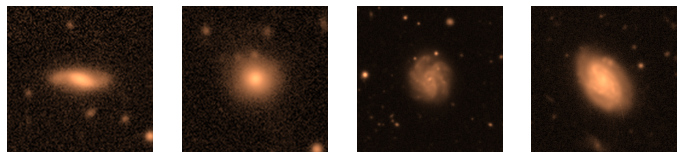

In [119]:
name = 'copper'
plt.figure(figsize = (12, 8))
plt.subplot(141)
plt.imshow(d1[0].permute(1, 2, 0), cmap=plt.get_cmap(name))
plt.axis('off')

plt.subplot(142)
plt.imshow(d2[0].permute(1, 2, 0), cmap=plt.get_cmap(name))
plt.axis('off')

plt.subplot(143)
plt.imshow(d3[0].permute(1, 2, 0), cmap=plt.get_cmap(name))
plt.axis('off')

plt.subplot(144)
plt.imshow(d4[0].permute(1, 2, 0), cmap=plt.get_cmap(name))
plt.axis('off')
plt.show()

# Pie Chart

- To repeat this for the entire dataset. 

In [22]:
import pandas as pd
import numpy as np 
import matplotlib.pylab as plt 
import matplotlib as cm
import settings as st
import os 

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 25

In [23]:
dataframe = pd.read_csv('ml/labels.csv')

In [24]:
def calc_percent_task(table: pd.DataFrame, task_number: int = 1):
    
    # sum across columns
    column_sum = table[st.LABELS['task_' + str(task_number)]].sum(0)
    
    # calculate percentage
    percentage = column_sum / column_sum.sum() * 100
    
    return percentage

In [25]:
test = [calc_percent_task(dataframe, i + 1) for i in range(10)]

In [26]:
def plot_pie(index: int = 0, save: bool = False):
    nobject = len(test[index].values)
    colors = iter([plt.cm.Pastel1(k) for k in range(nobject)])
    fig1, ax1 = plt.subplots(figsize=(12,12))
#     fig1.set_figheight(8)
#     fig1.set_figwidth(8)
    patches, texts, autotexts = ax1.pie(test[index].values, labels=test[index].keys(), autopct='%1.1f%%', shadow=False, colors = colors)
    plt.setp(texts, fontsize=fontSize)
    plt.setp(autotexts, fontsize=fontSize)

    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    ax1.axis('equal') 
    
    if save:
        path = 'plots/pie/'
        os.makedirs(path, exist_ok=True)
        plt.savefig(path + 'pie_' + str(index) + '.pdf', bbox_inches = 'tight')
        plt.savefig(path + 'pie_' + str(index) + '.png', bbox_inches = 'tight')
        plt.close()
        
    else:
        plt.show()

In [27]:
# for i in range(10):
#     plot_pie(i, True)

# Predictions from ML and MTL network

In [13]:
from src.postprocess import metric_multitask, metrics_multilabel

In [15]:
hl_class_ml, hl_ml = metrics_multilabel('ML_predictions_class', 'test')

Smooth                        : 0.138
Featured or Disk              : 0.143
Artifact                      : 0.029
Round                         : 0.133
In Between                    : 0.200
Cigar Shaped                  : 0.069
Edge On Disk (Yes)            : 0.099
Edge On Disk (No)             : 0.253
Merging (Merger)              : 0.073
Merging (Major Disturbance)   : 0.047
Merging (Minor Disturbance)   : 0.109
Merging (None)                : 0.133
Bulge (Rounded)               : 0.188
Bulge (Boxy)                  : 0.034
Bulge (None)                  : 0.072
No Bar                        : 0.341
Weak Bar                      : 0.137
Strong Bar                    : 0.060
Spiral Arms (Yes)             : 0.131
Spiral Arms (No)              : 0.360
Spiral Winding (Tight)        : 0.149
Spiral Winding (Medium)       : 0.133
Spiral Winding (Loose)        : 0.091
Spiral Arms (1)               : 0.035
Spiral Arms (2)               : 0.146
Spiral Arms (3)               : 0.031
Spiral Arms 

In [17]:
hl_class_mtl, hl_task_mtl = metric_multitask('MTL_predictions_targets_mtl-models-2022-6-2', 'test')

Overall Hamming loss is: 0.169
--------------------------------------------------
Task  1: 0.117
Task  2: 0.149
Task  3: 0.214
Task  4: 0.129
Task  5: 0.118
Task  6: 0.209
Task  7: 0.265
Task  8: 0.281
Task  9: 0.154
Task 10: 0.145
Smooth                        : 0.144
Featured or Disk              : 0.178
Artifact                      : 0.030
Round                         : 0.158
In Between                    : 0.212
Cigar Shaped                  : 0.077
Edge On Disk (Yes)            : 0.114
Edge On Disk (No)             : 0.314
Merging (Merger)              : 0.096
Merging (Major Disturbance)   : 0.061
Merging (Minor Disturbance)   : 0.188
Merging (None)                : 0.170
Bulge (Rounded)               : 0.211
Bulge (Boxy)                  : 0.062
Bulge (None)                  : 0.081
No Bar                        : 0.409
Weak Bar                      : 0.153
Strong Bar                    : 0.065
Spiral Arms (Yes)             : 0.152
Spiral Arms (No)              : 0.379
Spiral W

# Build the Tree

In [18]:
import settings as st 
import utils.helpers as hp
import src.processing as sp
import sklearn.metrics as sm
import pandas as pd
import numpy as np 

In [22]:
preds = hp.load_pickle('results', 'MTL_predictions_mtl-models-2022-6-2')
test = hp.load_csv('ml', 'test')

In [23]:
def labels_test(test: pd.DataFrame, index: int = 0):
    
    # the first two column names are the name and png locations
    labels = test.iloc[index, 2:]
    
    label_dict = dict()
    for i in range(st.NUM_TASKS):
        task = labels[st.LABELS['task_' + str(i + 1)]].values.astype(int)
        label_dict['task_' + str(i + 1)] = task
        
    return label_dict

In [24]:
ntest = test.shape[0]
tree_pred = list()
tree_test = list()

for idx in range(ntest):
    
    # re-write the test point in a dictionary (label per task)
    test_point = labels_test(test, idx)
          
    # find the labels (ground truths and test point)
    pred_labels = sp.find_labels(preds[idx])
    test_labels = sp.find_labels(test_point)
    
    # record the trees
    tree_pred.append(pred_labels)
    tree_test.append(test_labels)

In [25]:
tree_pred_df = pd.concat(tree_pred)
tree_test_df = pd.concat(tree_test)

In [26]:
tree_pred_df.reset_index(drop=True, inplace=True)
tree_test_df.reset_index(drop=True, inplace=True)

Save the outputs

In [14]:
# tree_pred_df.to_csv('results/tree_pred-'+date+'.csv', index=False)
# tree_test_df.to_csv('results/tree_test-'+date+'.csv', index=False)

# Visualise Image and Tree

In [15]:
import pandas as pd 
import sklearn.metrics as sm

In [17]:
tree_pred_df = pd.read_csv('results/tree_pred-'+date+'.csv')
tree_test_df = pd.read_csv('results/tree_test-'+date+'.csv')

In [52]:
idxs = [6510, 6511, 6512, 6513]
# idxs = [6, 7, 8, 9]

In [53]:
tree_pred_df.iloc[idxs]

,task_1,task_2,task_3,task_4,task_5,task_6,task_7,task_8,task_9,task_10
6510,['Smooth'],['Round'],NaN,['Merging (None)'],NaN,NaN,NaN,NaN,NaN,NaN
6511,['Smooth'],['In Between'],NaN,['Merging (None)'],NaN,NaN,NaN,NaN,NaN,NaN
6512,['Smooth'],['In Between'],NaN,['Merging (None)'],NaN,NaN,NaN,NaN,NaN,NaN
6513,['Featured or Disk'],NaN,['Edge On Disk (No)'],['Merging (None)'],NaN,['No Bar'],['Spiral Arms (Yes)'],['Spiral Winding (Tight)'],['Spiral Arms (2)'],['Central Bulge (Small)']


In [54]:
tree_test_df.iloc[idxs]

,task_1,task_2,task_3,task_4,task_5,task_6,task_7,task_8,task_9,task_10
6510,['Smooth'],"['Round', 'In Between']",NaN,['Merging (None)'],NaN,NaN,NaN,NaN,NaN,NaN
6511,['Featured or Disk'],NaN,['Edge On Disk (Yes)'],['Merging (None)'],['Bulge (Rounded)'],NaN,NaN,NaN,NaN,NaN
6512,['Smooth'],['In Between'],NaN,['Merging (None)'],NaN,NaN,NaN,NaN,NaN,NaN
6513,['Featured or Disk'],NaN,['Edge On Disk (No)'],['Merging (None)'],NaN,['No Bar'],['Spiral Arms (Yes)'],"['Spiral Winding (Tight)', 'Spiral Winding (Me...",['Spiral Arms (cannot tell)'],['Central Bulge (Small)']


In [55]:
test_dataset = DECaLSDataset(mode='test', augment=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

The number of test points is 37993


In [56]:
d1 = test_loader.dataset[idxs[0]]
d2 = test_loader.dataset[idxs[1]]
d3 = test_loader.dataset[idxs[2]]
d4 = test_loader.dataset[idxs[3]]

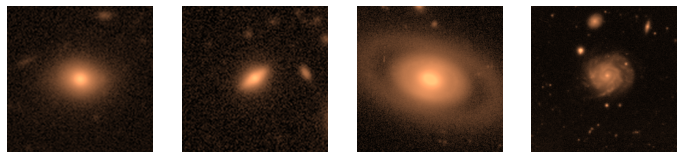

In [57]:
name = 'copper'
plt.figure(figsize = (12, 8))
plt.subplot(141)
plt.imshow(d1[0].permute(1, 2, 0), cmap=plt.get_cmap(name))
plt.axis('off')

plt.subplot(142)
plt.imshow(d2[0].permute(1, 2, 0), cmap=plt.get_cmap(name))
plt.axis('off')

plt.subplot(143)
plt.imshow(d3[0].permute(1, 2, 0), cmap=plt.get_cmap(name))
plt.axis('off')

plt.subplot(144)
plt.imshow(d4[0].permute(1, 2, 0), cmap=plt.get_cmap(name))
plt.axis('off')
plt.show()

### Count number of labels per task in the test set

In [24]:
def count_element(dataframe, task):
    
    ntest = dataframe.shape[0]
    
    record = []
    
    for i in range(ntest):
        
        element = dataframe[task].values[i]
        
        if not pd.isna(element):
            count = len(eval(element))
            
        else:
            count = 0 
            
        record.append(count)
        
    return pd.DataFrame(record, columns = [task])

In [25]:
tree_test_counts = []

for i in range(10):
    tree_test_counts.append(count_element(tree_test_df, 'task_'+str(i+1)))

In [26]:
tree_test_counts = pd.concat(tree_test_counts, axis = 1)

In [27]:
tree_test_counts.head()

,task_1,task_2,task_3,task_4,task_5,task_6,task_7,task_8,task_9,task_10
0,1,0,1,1,0,1,1,1,1,1
1,1,1,0,1,0,0,0,0,0,0
2,1,0,1,1,0,1,1,0,0,1
3,1,0,1,1,0,1,1,3,1,3
4,1,0,1,1,0,1,1,0,0,1


Select rows which has only one element

In [28]:
subset_test = tree_test_df[(tree_test_counts <= 1).all(1)]
subset_pred = tree_pred_df[(tree_test_counts <= 1).all(1)]

subset_test.reset_index(drop=True, inplace=True)
subset_pred.reset_index(drop=True, inplace=True)

In [29]:
print(f'Number of examples where we have unique labels is {subset_test.shape[0]}')

Number of examples where we have unique labels is 28838


In [30]:
subset_test.head()

,task_1,task_2,task_3,task_4,task_5,task_6,task_7,task_8,task_9,task_10
0,['Featured or Disk'],NaN,['Edge On Disk (No)'],['Merging (None)'],NaN,['No Bar'],['Spiral Arms (Yes)'],['Spiral Winding (Tight)'],['Spiral Arms (3)'],['Central Bulge (Small)']
1,['Smooth'],['Round'],NaN,['Merging (None)'],NaN,NaN,NaN,NaN,NaN,NaN
2,['Featured or Disk'],NaN,['Edge On Disk (No)'],['Merging (Merger)'],NaN,['No Bar'],['Spiral Arms (No)'],NaN,NaN,['Central Bulge (Dominant)']
3,['Featured or Disk'],NaN,['Edge On Disk (No)'],['Merging (None)'],NaN,['No Bar'],['Spiral Arms (No)'],NaN,NaN,['Central Bulge (Small)']
4,['Smooth'],['In Between'],NaN,['Merging (None)'],NaN,NaN,NaN,NaN,NaN,NaN


### Metrics for Multi-Task

Assign a specific label to the different labels

We are essentially removing the list and assigning only the label.

In [31]:
def process_element(dataframe):
    
    ntest = dataframe.shape[0]
    
    record = []
    
    for t in range(10):
        task = 'task_'+str(t+1)
        for i in range(ntest):

            element = dataframe[task].values[i]

            if not pd.isna(element):
                dataframe[task].iloc[i] = eval(element)[0]
        
    return dataframe

In [32]:
df_pred = subset_pred.copy()
df_test = subset_test.copy()

In [33]:
df_test.head()

,task_1,task_2,task_3,task_4,task_5,task_6,task_7,task_8,task_9,task_10
0,['Featured or Disk'],NaN,['Edge On Disk (No)'],['Merging (None)'],NaN,['No Bar'],['Spiral Arms (Yes)'],['Spiral Winding (Tight)'],['Spiral Arms (3)'],['Central Bulge (Small)']
1,['Smooth'],['Round'],NaN,['Merging (None)'],NaN,NaN,NaN,NaN,NaN,NaN
2,['Featured or Disk'],NaN,['Edge On Disk (No)'],['Merging (Merger)'],NaN,['No Bar'],['Spiral Arms (No)'],NaN,NaN,['Central Bulge (Dominant)']
3,['Featured or Disk'],NaN,['Edge On Disk (No)'],['Merging (None)'],NaN,['No Bar'],['Spiral Arms (No)'],NaN,NaN,['Central Bulge (Small)']
4,['Smooth'],['In Between'],NaN,['Merging (None)'],NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
# process the dataframe
df_processed_pred = process_element(df_pred)
df_processed_test = process_element(df_test)

In [35]:
df_processed_test.head()

,task_1,task_2,task_3,task_4,task_5,task_6,task_7,task_8,task_9,task_10
0,Featured or Disk,NaN,Edge On Disk (No),Merging (None),NaN,No Bar,Spiral Arms (Yes),Spiral Winding (Tight),Spiral Arms (3),Central Bulge (Small)
1,Smooth,Round,NaN,Merging (None),NaN,NaN,NaN,NaN,NaN,NaN
2,Featured or Disk,NaN,Edge On Disk (No),Merging (Merger),NaN,No Bar,Spiral Arms (No),NaN,NaN,Central Bulge (Dominant)
3,Featured or Disk,NaN,Edge On Disk (No),Merging (None),NaN,No Bar,Spiral Arms (No),NaN,NaN,Central Bulge (Small)
4,Smooth,In Between,NaN,Merging (None),NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
def overall_mapping(df_test, df_pred):
    
    mapping = {}
    
    count = 1
    
    for t in range(10):
        for l in st.LABELS['task_'+str(t+1)]:
            mapping[l] = count
            count += 1
            
    df_pred_mapped = df_pred.applymap(lambda s: mapping.get(s) if s in mapping else s) 
    df_test_mapped = df_test.applymap(lambda s: mapping.get(s) if s in mapping else s)
    
    df_pred_mapped = df_pred_mapped.fillna(0)
    df_test_mapped = df_test_mapped.fillna(0)

    df_pred_mapped = df_pred_mapped.astype(int)
    df_test_mapped = df_test_mapped.astype(int)
    
    return df_test_mapped, df_pred_mapped

In [111]:
def hamming_per_task(df_test, df_pred, task):
    
    # build the mapping 
    mapping = {st.LABELS[task][i]: i+1 for i in range(len(st.LABELS[task]))}
       
    df_pred_mapped = df_pred[task].map(mapping)
    df_test_mapped = df_test[task].map(mapping)
    
    df_pred_mapped = df_pred_mapped.fillna(0)
    df_test_mapped = df_test_mapped.fillna(0)
    
    df_pred_mapped = df_pred_mapped.astype(int)
    df_test_mapped = df_test_mapped.astype(int)
    
    ham_loss = sm.hamming_loss(df_test_mapped, df_pred_mapped)
    
    return ham_loss

In [112]:
import settings as st

In [113]:
for i in range(10):
    hl = hamming_per_task(df_processed_test, df_processed_pred, 'task_'+str(i+1))
    print(f'Task {i+1}: {hl:.3f}')
    print('-'*100)

Task 1: 0.232
----------------------------------------------------------------------------------------------------
Task 2: 0.489
----------------------------------------------------------------------------------------------------
Task 3: 0.248
----------------------------------------------------------------------------------------------------
Task 4: 0.147
----------------------------------------------------------------------------------------------------
Task 5: 0.068
----------------------------------------------------------------------------------------------------
Task 6: 0.236
----------------------------------------------------------------------------------------------------
Task 7: 0.229
----------------------------------------------------------------------------------------------------
Task 8: 0.200
----------------------------------------------------------------------------------------------------
Task 9: 0.196
------------------------------------------------------------------

In [40]:
df1, df2 = overall_mapping(df_processed_test, df_processed_pred)

In [105]:
def metrics(df_test, df_pred):
    
    for i in range(10):
        task = 'task_'+str(i+1)
        
        acc = sm.accuracy_score(df_test[task], df_pred[task], normalize=True, sample_weight=None)
        ham = sm.hamming_loss(df_test[task], df_pred[task])
        pre = sm.precision_score(df_test[task], df_pred[task], average = "micro")
        rec = sm.recall_score(df_test[task], df_pred[task], average = "micro")
        f_1 = sm.f1_score(df_test[task], df_pred[task], average = "micro")
        
        print(f'Accuracy Score for Task {i+1}  : {acc:.3f}')
        print(f'Hamming Score for Task {i+1}   : {ham:.3f}')
        print(f'Precision Score for Task {i+1} : {pre:.3f}')
        print(f'Recall Score for Task {i+1}    : {rec:.3f}')
        print(f'F1 Score for Task {i+1}        : {f_1:.3f}')
        print('-'*50)

In [107]:
metrics(df1, df2)

Accuracy Score for Task 1  : 0.768
Hamming Score for Task 1   : 0.232
Precision Score for Task 1 : 0.768
Recall Score for Task 1    : 0.768
F1 Score for Task 1        : 0.768
--------------------------------------------------
Accuracy Score for Task 2  : 0.511
Hamming Score for Task 2   : 0.489
Precision Score for Task 2 : 0.511
Recall Score for Task 2    : 0.511
F1 Score for Task 2        : 0.511
--------------------------------------------------
Accuracy Score for Task 3  : 0.752
Hamming Score for Task 3   : 0.248
Precision Score for Task 3 : 0.752
Recall Score for Task 3    : 0.752
F1 Score for Task 3        : 0.752
--------------------------------------------------
Accuracy Score for Task 4  : 0.853
Hamming Score for Task 4   : 0.147
Precision Score for Task 4 : 0.853
Recall Score for Task 4    : 0.853
F1 Score for Task 4        : 0.853
--------------------------------------------------
Accuracy Score for Task 5  : 0.932
Hamming Score for Task 5   : 0.068
Precision Score for Task 5

# Number of Similar Trees

In [43]:
x = df1 == df2

In [44]:
frac = sum(x.all(1) * 1) / x.shape[0] * 100

print(f'Percentage of similar trees is {frac:.2f}')

Percentage of similar trees is 34.61


# Representations

In [1]:
import os
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

# our scripts and functions
from src.network import MultiLabelNet, MultiTaskNet
from src.dataset import DECaLSDataset
import settings as st

import matplotlib.pylab as plt 
import matplotlib as cm

# plt.rc('text', usetex=True)
# plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
# figSize  = (12, 8)
# fontSize = 25

In [20]:
tree_pred_df = pd.read_csv('results/tree_pred.csv')
tree_test_df = pd.read_csv('results/tree_test.csv')

In [49]:
# tree_test_df[tree_test_df['task_1'] == "['Artifact']"]

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [34]:
# load the model
loaded_model = torch.load('../mtl-models/resnet_18_multitask_18.pth')
model = MultiTaskNet(backbone="resnet18", output_size=st.LABELS_PER_TASK, resnet_task=True)
model.to(device)
model.load_state_dict(loaded_model)

<All keys matched successfully>

In [35]:
test_dataset = DECaLSDataset(mode='test', augment=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

The number of test points is 37993


In [36]:
data = test_loader.dataset[412]

In [37]:
def representations(model, data):
    
    backbone = nn.Sequential(*list(model.children())[:-1])
    shared = backbone(data[0].view(1, 1, 224, 224).to(device))
    
    decoders = list(model.children())[1]
    
    dec = {}
    
    for k in range(10):
        task = 'task_' + str(k+1)
        model = nn.Sequential(*list(decoders[task].children())[:-1])
        dec[task] = model(shared.view(1, 1, 1000)).view(-1)
        
    return shared.view(-1), dec

In [38]:
fixed = representations(model, data)

In [39]:
pdist = nn.PairwiseDistance(p=2)

In [40]:
record = []

for i in range(37993):
    
    toAppend = {}
    
    ith_data = test_loader.dataset[i]
    
    shared, tasks = representations(model, ith_data)
    
    dist_shared = pdist(fixed[0], shared)
    
    toAppend['shared'] = dist_shared.item()
    
    for m in range(10):
        t = 'task_' + str(m + 1)
        dist_task = pdist(fixed[1][t], tasks[t])
        
        toAppend[t]= dist_task.item()

    record.append(toAppend)

In [41]:
distances_df = pd.DataFrame(record)

In [42]:
distances_df.sort_values(by=['shared']).head(10)

,shared,task_1,task_2,task_3,task_4,task_5,task_6,task_7,task_8,task_9,task_10
412,0.000032,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016
29310,1.235613,0.553905,0.624848,0.588287,0.543028,0.522510,0.556082,0.503247,0.542599,0.375840,0.504523
27644,1.256936,0.597060,0.626190,0.549091,0.575931,0.480167,0.552496,0.542654,0.496375,0.413801,0.509646
2321,1.266995,0.680314,0.712486,0.500529,0.609968,0.493514,0.607705,0.560549,0.581498,0.406113,0.570744
33605,1.272773,0.621829,0.657887,0.596962,0.609921,0.528535,0.612333,0.569649,0.539344,0.449902,0.552893
36111,1.275903,0.669533,0.664708,0.598438,0.527787,0.467860,0.582840,0.533597,0.483811,0.398207,0.548394
33272,1.316638,0.597452,0.695939,0.621969,0.591870,0.517066,0.593607,0.503542,0.584836,0.468041,0.519052
26192,1.316992,0.658251,0.674703,0.574814,0.555732,0.548993,0.687971,0.565201,0.557437,0.434887,0.580272
3884,1.318765,0.628982,0.682970,0.535639,0.586816,0.556882,0.626671,0.530337,0.580935,0.425289,0.579869
16839,1.331554,0.687595,0.659574,0.547028,0.611198,0.500210,0.644508,0.581222,0.536028,0.440493,0.669364


In [43]:
# distances_df.to_csv('results/distances_artifacts.csv')

### Load Distances

In [44]:
distances_df = pd.read_csv('results/distances_artifacts.csv').iloc[:,1:]

In [58]:
nobjects = 35

idxs = list(distances_df.sort_values(by=['shared']).head(nobjects).index)

In [59]:
# plt.imshow(test_loader.dataset[412][0].permute(1, 2, 0), cmap=plt.get_cmap(name))
# plt.axis('off')
# plt.show()

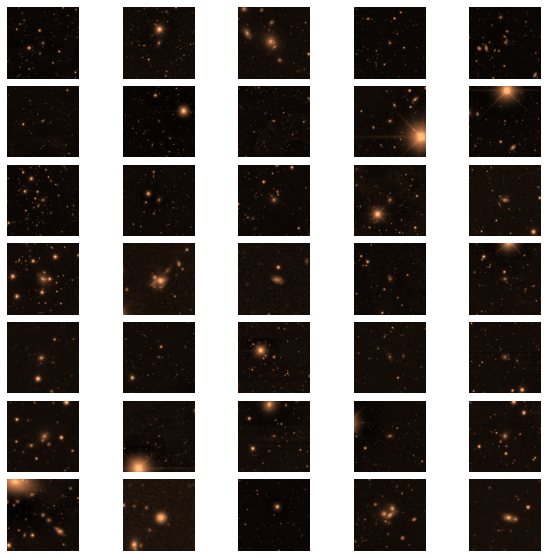

In [62]:
name = 'copper'
plt.figure(figsize = (10, 10))
for i in range(nobjects):
    plt.subplot(7, 5, i+1)
    plt.imshow(test_loader.dataset[idxs[i]][0].permute(1, 2, 0), cmap=plt.get_cmap(name))
    plt.axis('off')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.1)
# plt.savefig('plots/neighbours_artifacts.pdf', bbox_inches = 'tight')
plt.show()